In [ ]:
import os
from tqdm import tqdm
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder

# Import regression models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import catboost as cb
import xgboost as xgb
import lightgbm as lgb

# Hyperparameter tuning
import optuna
from optuna.samplers import TPESampler

# Save models
import joblib

import warnings
warnings.filterwarnings('ignore')

In [53]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
ss = pd.read_csv('data/sample_submission.csv')

In [54]:
train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [55]:
test.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [56]:
year = datetime.datetime.now().year
train['age'] = train['model_year'].apply(lambda x: year-x)
train

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,age
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,18
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,23
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,23
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,8
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,None reported,Yes,27500,8
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,30000,7
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,None reported,Yes,86900,4
188531,188531,Audi,S5 3.0T Prestige,2022,13895,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,None reported,NaN,84900,3


<Axes: >

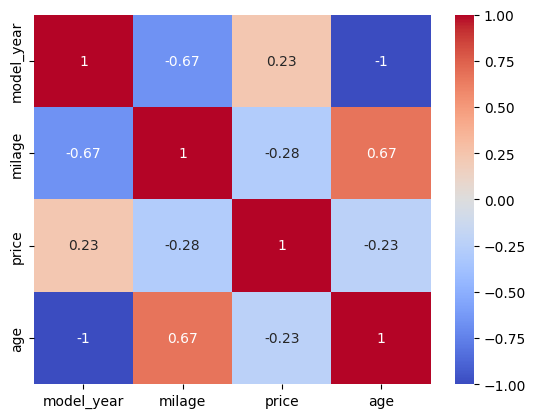

In [57]:
corr_matrix = train[train.select_dtypes(include=['number']).drop(columns=['id']).columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [58]:
train.describe()

,id,model_year,milage,price,age
count,188533.000000,188533.000000,188533.000000,1.885330e+05,188533.000000
mean,94266.000000,2015.829998,65705.295174,4.387802e+04,9.170002
std,54424.933488,5.660967,49798.158076,7.881952e+04,5.660967
min,0.000000,1974.000000,100.000000,2.000000e+03,1.000000
25%,47133.000000,2013.000000,24115.000000,1.700000e+04,5.000000
50%,94266.000000,2017.000000,57785.000000,3.082500e+04,8.000000
75%,141399.000000,2020.000000,95400.000000,4.990000e+04,12.000000
max,188532.000000,2024.000000,405000.000000,2.954083e+06,51.000000


In [59]:
train['accident'].value_counts()

accident
None reported                             144514
At least 1 accident or damage reported     41567
Name: count, dtype: int64

In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
 13  age           188533 non-null  int64 
dtypes: int64(5), object(9)
memory usage: 20.1+ MB


In [61]:
train.describe()

,id,model_year,milage,price,age
count,188533.000000,188533.000000,188533.000000,1.885330e+05,188533.000000
mean,94266.000000,2015.829998,65705.295174,4.387802e+04,9.170002
std,54424.933488,5.660967,49798.158076,7.881952e+04,5.660967
min,0.000000,1974.000000,100.000000,2.000000e+03,1.000000
25%,47133.000000,2013.000000,24115.000000,1.700000e+04,5.000000
50%,94266.000000,2017.000000,57785.000000,3.082500e+04,8.000000
75%,141399.000000,2020.000000,95400.000000,4.990000e+04,12.000000
max,188532.000000,2024.000000,405000.000000,2.954083e+06,51.000000


In [62]:
null_train = train.isnull().sum()
null_test = test.isnull().sum()
null_df = pd.concat([null_train, null_test], axis=1, keys=['train', 'test'])
null_df['% missing train'] = null_df['train']/len(train)
null_df['% missing test'] = null_df['test']/len(test)
null_df

,train,test,% missing train,% missing test
id,0,0.0,0.000000,0.000000
brand,0,0.0,0.000000,0.000000
model,0,0.0,0.000000,0.000000
model_year,0,0.0,0.000000,0.000000
milage,0,0.0,0.000000,0.000000
fuel_type,5083,3383.0,0.026961,0.026915
engine,0,0.0,0.000000,0.000000
transmission,0,0.0,0.000000,0.000000
ext_col,0,0.0,0.000000,0.000000
int_col,0,0.0,0.000000,0.000000


In [63]:
print("duplicate train: ", train.duplicated().sum())
print("duplicate test: ", test.duplicated().sum())

duplicate train:  0
duplicate test:  0


In [64]:
train.fuel_type.value_counts()


fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

In [65]:
test.fuel_type.value_counts()

fuel_type
Gasoline          110533
Hybrid              4676
E85 Flex Fuel       3523
Diesel              2686
–                    538
Plug-In Hybrid       337
not supported         14
Name: count, dtype: int64

In [66]:
print(train['engine'].iloc[0])

172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel


In [67]:
fuel_missing_df = train[train['fuel_type'].isnull()]
fuel_missing_df.brand.value_counts()
# Tesla is electric 

brand
Tesla            3361
Rivian            497
Ford              427
Porsche           190
Audi              121
Mercedes-Benz      61
BMW                60
Nissan             56
Kia                54
Lucid              52
Chevrolet          43
Hyundai            29
Volkswagen         28
Toyota             16
Karma              12
Volvo               9
Acura               8
Cadillac            7
Dodge               7
GMC                 5
Polestar            5
Jeep                4
Land                4
MINI                3
Jaguar              2
RAM                 2
Bentley             2
Pontiac             2
Genesis             2
INFINITI            2
FIAT                2
smart               1
Maserati            1
Ferrari             1
McLaren             1
Chrysler            1
Lotus               1
Mitsubishi          1
Lamborghini         1
Lincoln             1
Alfa                1
Name: count, dtype: int64

In [68]:
train.clean_title.value_counts()

clean_title
Yes    167114
Name: count, dtype: int64

In [69]:
clean_title_missing_df = train[train['clean_title'].isnull()]

In [70]:
def feature_engineering(df):

    year = datetime.datetime.now().year
    df['age'] = df['model_year'].apply(lambda x: year-x)

    df['risk_dead_engine'] = df['milage'].map(lambda x: 1 if x>300000 else 0)

    def overworked(row):
        if row['milage']>50000 and row['age']<1:
            return 1
        elif row['milage']>100000 and row['age']<2:
            return 1
        elif row['milage']>300000 and row['age']<10:
            return 1
        return 0

    def fresh_engine(row):
        if row['milage']<10000:
            return 1
        if row['milage']<30000 and row['age']>=2:
            return 1
        return 0
    df['overworked'] = df.apply(overworked, axis=1)
    df['fresh_engine'] = df.apply(fresh_engine, axis=1)


    df['Cylinder'] = df['engine'].str.extract(r'(\d+)\s+Cylinder', expand=False).fillna(-1).astype(int)

    df['engine_Litr'] = df['engine'].str.extract(r'(\d+\.\d+)\s+L', expand=False).fillna(-1).astype(float)

    return df

In [71]:
test_ids = test['id']
def preprocess_data(train, test):

    # drop duplicates
    train = train.drop_duplicates()

    # concat train and test
    test['price'] = -1
    df = pd.concat([train, test], axis=0, ignore_index=True)

    # missing values :

    ## fuel_type
    mask = df['fuel_type'].isnull()
    df.loc[mask, 'fuel_type'] = df.loc[mask, 'engine'].map(lambda x: 'Plug-In Hybrid' if 'Plug-In' in x else 'Hybrid' if 'Hybrid' in x else 'Gasoline' if 'Gasoline' in x else 'E85 Flex Fuel' if 'Flex Fuel' in x else  'Diesel' if 'Diesel|GDI' in x else 'Other')
    ## clean_title
    mask = df['clean_title'].isnull()
    df.loc[mask, 'clean_title'] = 'No'
    ## accident 
    mask = df['accident'].isnull()
    df.loc[mask, 'accident'] = 'None reported'

    # feature engineering
    df = feature_engineering(df)


    # drop null values
    # df.dropna(inplace=True)

    # drop cols
    cols = ['id']
    df.drop(cols, axis=1, inplace=True)


    # Encode categorical features
    ## feature to one hot encoding
    features_to_1hotEncode = ['accident']
    df = pd.get_dummies(df, columns=features_to_1hotEncode)

    train = df[df['price']!=-1]
    test = df[df['price']==-1]

    ## feature for label encoding
    cols_to_LabelEncode = train.select_dtypes(include=['object']).columns
    le = LabelEncoder()

    for col in tqdm(cols_to_LabelEncode,desc='Encoding categorical features'):
        if col in train.columns and col in test.columns:
            classes_ = train[col].unique()
            train[col] = le.fit_transform(train[col])
            test[col] = test[col].map(lambda x: le.transform([x])[0] if x in classes_ else -1)

    return train, test

In [72]:
train, test = preprocess_data(train, test)

Encoding categorical features: 100%|██████████| 8/8 [03:35<00:00, 26.95s/it]


In [73]:
train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,clean_title,price,age,risk_dead_engine,overworked,fresh_engine,Cylinder,engine_Litr,accident_At least 1 accident or damage reported,accident_None reported
0,31,495,2007,213000,2,116,38,312,71,1,4200,18,0,0,0,4,-1.0,False,True
1,28,930,2002,143250,2,366,38,263,10,1,4999,23,0,0,0,8,-1.0,True,False
2,9,1575,2002,136731,1,640,38,38,71,1,13900,23,0,0,0,8,-1.0,False,True
3,16,758,2017,19500,2,863,49,29,14,1,45000,8,0,0,1,8,-1.0,False,True
4,36,1077,2021,7388,2,259,23,29,10,1,97500,4,0,0,1,4,-1.0,False,True


In [74]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('price', axis=1), train['price'], test_size=0.2, random_state=42)

In [75]:
cat_model = cb.CatBoostRegressor(loss_function='RMSE', verbose=0)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
lgb_model = lgb.LGBMRegressor(objective='regression', metric='rmse', random_state=42,verbose=-1)
rf_model = RandomForestRegressor(random_state=42)

models = [cat_model, xgb_model, lgb_model, rf_model]

In [76]:
def objective_catboost(trial):
    cat_params = {
        'iterations': trial.suggest_int('cat_iterations', 100, 1000),
        'learning_rate': trial.suggest_float('cat_learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('cat_depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('cat_l2_leaf_reg', 1, 10)
    }
    
    cat_model = cb.CatBoostRegressor(loss_function='RMSE', verbose=0, **cat_params)
    cat_model.fit(X_train, y_train)
    y_pred = cat_model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    return rmse

def objective_xgb(trial):
    xgb_params = {
        'n_estimators': trial.suggest_int('xgb_n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('xgb_learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 10),
        'subsample': trial.suggest_float('xgb_subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.6, 1.0)
    }
    
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **xgb_params)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    return rmse

def objective_lgb(trial):
    lgb_params = {
        'n_estimators': trial.suggest_int('lgb_n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('lgb_learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('lgb_max_depth', 3, 10),
        'subsample': trial.suggest_float('lgb_subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('lgb_colsample_bytree', 0.6, 1.0)
    }
    
    lgb_model = lgb.LGBMRegressor(objective='regression', metric='rmse', random_state=42, verbose=-1, **lgb_params)
    lgb_model.fit(X_train, y_train)
    y_pred = lgb_model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    return rmse

def objective_rf(trial):
    rf_params = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('rf_max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 5)
    }
    
    rf_model = RandomForestRegressor(random_state=42, **rf_params)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    return rmse

In [77]:
print("Optimizing CatBoost...")
cat_study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
cat_study.optimize(objective_catboost, n_trials=30)

[I 2025-09-05 02:50:18,098] A new study created in memory with name: no-name-9e6c8f61-53a0-4dea-8907-fda0739706f6


Optimizing CatBoost...


[I 2025-09-05 02:50:23,113] Trial 0 finished with value: 68852.25716300363 and parameters: {'cat_iterations': 437, 'cat_learning_rate': 0.28570714885887566, 'cat_depth': 9, 'cat_l2_leaf_reg': 6.387926357773329}. Best is trial 0 with value: 68852.25716300363.
[I 2025-09-05 02:50:24,388] Trial 1 finished with value: 68186.19058696463 and parameters: {'cat_iterations': 240, 'cat_learning_rate': 0.055238410897498764, 'cat_depth': 4, 'cat_l2_leaf_reg': 8.795585311974417}. Best is trial 1 with value: 68186.19058696463.
[I 2025-09-05 02:50:27,665] Trial 2 finished with value: 68009.85885809295 and parameters: {'cat_iterations': 641, 'cat_learning_rate': 0.21534104756085318, 'cat_depth': 4, 'cat_l2_leaf_reg': 9.72918866945795}. Best is trial 2 with value: 68009.85885809295.
[I 2025-09-05 02:50:32,338] Trial 3 finished with value: 68064.74866406902 and parameters: {'cat_iterations': 850, 'cat_learning_rate': 0.07157834209670008, 'cat_depth': 5, 'cat_l2_leaf_reg': 2.650640588680904}. Best is tri

In [78]:
print("Optimizing XGBoost...")
xgb_study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
xgb_study.optimize(objective_xgb, n_trials=50)

[I 2025-09-05 02:52:37,342] A new study created in memory with name: no-name-e5b76963-d799-4db0-901c-07ed204b74cf


Optimizing XGBoost...


[I 2025-09-05 02:52:39,238] Trial 0 finished with value: 77092.953125 and parameters: {'xgb_n_estimators': 437, 'xgb_learning_rate': 0.28570714885887566, 'xgb_max_depth': 8, 'xgb_subsample': 0.8394633936788146, 'xgb_colsample_bytree': 0.6624074561769746}. Best is trial 0 with value: 77092.953125.
[I 2025-09-05 02:52:40,577] Trial 1 finished with value: 69464.953125 and parameters: {'xgb_n_estimators': 240, 'xgb_learning_rate': 0.026844247528777843, 'xgb_max_depth': 9, 'xgb_subsample': 0.8404460046972835, 'xgb_colsample_bytree': 0.8832290311184181}. Best is trial 1 with value: 69464.953125.
[I 2025-09-05 02:52:41,242] Trial 2 finished with value: 76302.5859375 and parameters: {'xgb_n_estimators': 118, 'xgb_learning_rate': 0.29127385712697834, 'xgb_max_depth': 9, 'xgb_subsample': 0.6849356442713105, 'xgb_colsample_bytree': 0.6727299868828402}. Best is trial 1 with value: 69464.953125.
[I 2025-09-05 02:52:42,218] Trial 3 finished with value: 70170.3203125 and parameters: {'xgb_n_estimator

In [79]:
print("Optimizing LightGBM...")
lgb_study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
lgb_study.optimize(objective_lgb, n_trials=50)

[I 2025-09-05 02:53:45,517] A new study created in memory with name: no-name-b43697d6-893f-4b91-8645-11b6a15e90b9


Optimizing LightGBM...


[I 2025-09-05 02:53:46,343] Trial 0 finished with value: 70596.9088098689 and parameters: {'lgb_n_estimators': 437, 'lgb_learning_rate': 0.28570714885887566, 'lgb_max_depth': 8, 'lgb_subsample': 0.8394633936788146, 'lgb_colsample_bytree': 0.6624074561769746}. Best is trial 0 with value: 70596.9088098689.
[I 2025-09-05 02:53:46,913] Trial 1 finished with value: 67915.75115130021 and parameters: {'lgb_n_estimators': 240, 'lgb_learning_rate': 0.026844247528777843, 'lgb_max_depth': 9, 'lgb_subsample': 0.8404460046972835, 'lgb_colsample_bytree': 0.8832290311184181}. Best is trial 1 with value: 67915.75115130021.
[I 2025-09-05 02:53:47,218] Trial 2 finished with value: 68904.41939756437 and parameters: {'lgb_n_estimators': 118, 'lgb_learning_rate': 0.29127385712697834, 'lgb_max_depth': 9, 'lgb_subsample': 0.6849356442713105, 'lgb_colsample_bytree': 0.6727299868828402}. Best is trial 1 with value: 67915.75115130021.
[I 2025-09-05 02:53:47,758] Trial 3 finished with value: 68170.47130048808 an

In [80]:
print("Optimizing Random Forest...")
rf_study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
rf_study.optimize(objective_rf, n_trials=10)

[I 2025-09-05 02:54:28,809] A new study created in memory with name: no-name-c3f0da24-8620-4ede-b80d-b112569c3301


Optimizing Random Forest...


[I 2025-09-05 02:58:28,624] Trial 0 finished with value: 69289.14767269949 and parameters: {'rf_n_estimators': 437, 'rf_max_depth': 20, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 3}. Best is trial 0 with value: 69289.14767269949.
[I 2025-09-05 02:59:21,473] Trial 1 finished with value: 68568.733347644 and parameters: {'rf_n_estimators': 240, 'rf_max_depth': 7, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 5}. Best is trial 1 with value: 68568.733347644.
[I 2025-09-05 03:04:15,576] Trial 2 finished with value: 68622.95626751787 and parameters: {'rf_n_estimators': 641, 'rf_max_depth': 16, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 5}. Best is trial 1 with value: 68568.733347644.
[I 2025-09-05 03:08:14,075] Trial 3 finished with value: 68868.1055595733 and parameters: {'rf_n_estimators': 850, 'rf_max_depth': 8, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 1}. Best is trial 1 with value: 68568.733347644.
[I 2025-09-05 03:10:52,166] Trial 4 finished with value: 69678.

In [88]:
# Print best results for each model
print(f"\nBest CatBoost RMSE: {cat_study.best_value:.2f}")
print(f"Best XGBoost RMSE: {xgb_study.best_value:.2f}")
print(f"Best LightGBM RMSE: {lgb_study.best_value:.2f}")
print(f"Best Random Forest RMSE: {rf_study.best_value:.2f}")

# Calculate NRMSE for each model
y_mean = y_train.mean()
print(f"\nBest CatBoost NRMSE: {cat_study.best_value / y_mean:.4f}")
print(f"Best XGBoost NRMSE: {xgb_study.best_value / y_mean:.4f}")
print(f"Best LightGBM NRMSE: {lgb_study.best_value / y_mean:.4f}")
print(f"Best Random Forest NRMSE: {rf_study.best_value / y_mean:.4f}")

# Update models with best parameters from individual studies
cat_best_params = cat_study.best_params
xgb_best_params = xgb_study.best_params
lgb_best_params = lgb_study.best_params
rf_best_params = rf_study.best_params

# Fix parameter names for CatBoost
cat_params_fixed = {}
for key, value in cat_best_params.items():
    if key == 'cat_iterations':
        cat_params_fixed['iterations'] = value
    elif key == 'cat_learning_rate':
        cat_params_fixed['learning_rate'] = value
    elif key == 'cat_depth':
        cat_params_fixed['depth'] = value
    elif key == 'cat_l2_leaf_reg':
        cat_params_fixed['l2_leaf_reg'] = value
    else:
        cat_params_fixed[key] = value

# Fix parameter names for XGBoost
xgb_params_fixed = {}
for key, value in xgb_best_params.items():
    if key.startswith('xgb_'):
        xgb_params_fixed[key[4:]] = value  # Remove 'xgb_' prefix
    else:
        xgb_params_fixed[key] = value

# Fix parameter names for LightGBM
lgb_params_fixed = {}
for key, value in lgb_best_params.items():
    if key.startswith('lgb_'):
        lgb_params_fixed[key[4:]] = value  # Remove 'lgb_' prefix
    else:
        lgb_params_fixed[key] = value

# Fix parameter names for Random Forest
rf_params_fixed = {}
for key, value in rf_best_params.items():
    if key.startswith('rf_'):
        rf_params_fixed[key[3:]] = value  # Remove 'rf_' prefix
    else:
        rf_params_fixed[key] = value

# Create optimized models
cat_model = cb.CatBoostRegressor(loss_function='RMSE', verbose=0, **cat_params_fixed)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **xgb_params_fixed)
lgb_model = lgb.LGBMRegressor(objective='regression', metric='rmse', random_state=42, verbose=-1, **lgb_params_fixed)
rf_model = RandomForestRegressor(random_state=42, **rf_params_fixed)

models = [cat_model, xgb_model, lgb_model, rf_model]


Best CatBoost RMSE: 67889.82
Best XGBoost RMSE: 67920.55
Best LightGBM RMSE: 67790.92
Best Random Forest RMSE: 68568.73

Best CatBoost NRMSE: 1.5468
Best XGBoost NRMSE: 1.5475
Best LightGBM NRMSE: 1.5445
Best Random Forest NRMSE: 1.5623


In [ ]:
# Save the best parameters to a file for reuse


best_params = {
    'catboost': cat_params_fixed,
    'xgboost': xgb_params_fixed,
    'lightgbm': lgb_params_fixed,
    'randomforest': rf_params_fixed
}

# Create folder for saving parameters
params_folder = 'model_params'
os.makedirs(params_folder, exist_ok=True)

# Save parameters to JSON file
with open(f'{params_folder}/best_hyperparameters.json', 'w') as f:
    json.dump(best_params, f, indent=4)

print("Best hyperparameters saved to model_params/best_hyperparameters.json")
print("\nSaved parameters:")
for model_name, params in best_params.items():
    print(f"\n{model_name.upper()}:")
    for param, value in params.items():
        print(f"  {param}: {value}")


Best hyperparameters saved to model_params/best_hyperparameters.json

Saved parameters:

CATBOOST:
  iterations: 374
  learning_rate: 0.03832491306185132
  depth: 8
  l2_leaf_reg: 4.961372443656412

XGBOOST:
  n_estimators: 647
  learning_rate: 0.059451995869314544
  max_depth: 3
  subsample: 0.9795542149013333
  colsample_bytree: 0.9862528132298237

LIGHTGBM:
  n_estimators: 304
  learning_rate: 0.029362993761239693
  max_depth: 9
  subsample: 0.6668082178920786
  colsample_bytree: 0.7844707023078049

RANDOMFOREST:
  n_estimators: 240
  max_depth: 7
  min_samples_split: 2
  min_samples_leaf: 5


In [87]:
folder_name = 'submission'
os.makedirs(folder_name, exist_ok=True)

# Make predictions on the test set
test_predictions = []

# Remove 'price' column from test data if it exists
test_features = test.drop('price', axis=1) if 'price' in test.columns else test

for model in models:
    model.fit(train.drop('price', axis=1), train['price'])
    pred = model.predict(test_features)
    test_predictions.append(pred)
    
    # Create individual submission file for each model
    model_submission = pd.DataFrame({
        'id': test_ids,
        'price': pred
    })
    
    model_name = model.__class__.__name__
    model_submission.to_csv(f'{folder_name}/submission_{model_name}.csv', index=False)
    print(f"{model_name} submission file created successfully!")

# Create ensemble prediction (average of all models)
ensemble_pred = np.mean(test_predictions, axis=0)

# Create ensemble submission file
ensemble_submission = pd.DataFrame({
    'id': test_ids,
    'price': ensemble_pred
})

ensemble_submission.to_csv(f'{folder_name}/submission_ensemble.csv', index=False)
print("Ensemble submission file created successfully!")
print(ensemble_submission.head())


CatBoostRegressor submission file created successfully!
XGBRegressor submission file created successfully!
LGBMRegressor submission file created successfully!
RandomForestRegressor submission file created successfully!
Ensemble submission file created successfully!
       id         price
0  188533  17238.133178
1  188534  80504.347044
2  188535  54342.295709
3  188536  23339.076301
4  188537  30545.590341


In [ ]:
# Create models directory
models_folder = './backend/models'
os.makedirs(models_folder, exist_ok=True)

# Save all trained models
for model in models:
    model_name = model.__class__.__name__
    model_filename = f'{models_folder}/{model_name}.pkl'
    joblib.dump(model, model_filename)
    print(f"{model_name} model saved to {model_filename}")

print("\nAll models saved successfully!")


CatBoostRegressor model saved to ./backend/models/CatBoostRegressor.pkl
XGBRegressor model saved to ./backend/models/XGBRegressor.pkl
LGBMRegressor model saved to ./backend/models/LGBMRegressor.pkl
RandomForestRegressor model saved to ./backend/models/RandomForestRegressor.pkl

All models saved successfully!
